LSTM 모델 써보기

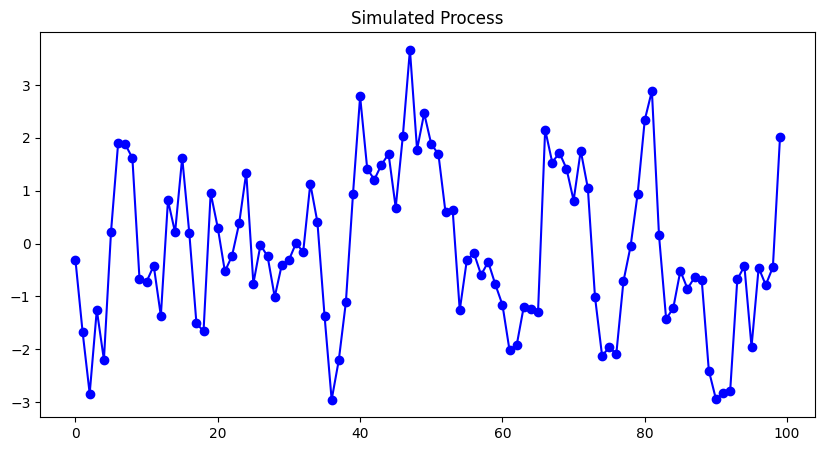

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Generate the data
import numpy as np
ar = np.array([1, -0.8, 0.2])
ma = np.array([1])
my_simulation = ArmaProcess(ar, ma).generate_sample(nsample=100)

plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(my_simulation, linestyle='-', marker='o', color='b')
plt.title("Simulated Process")
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


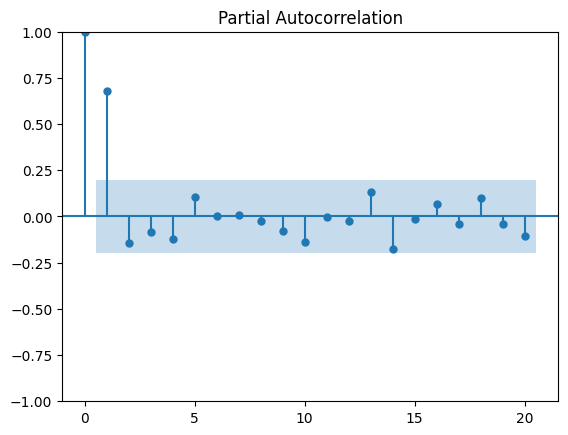

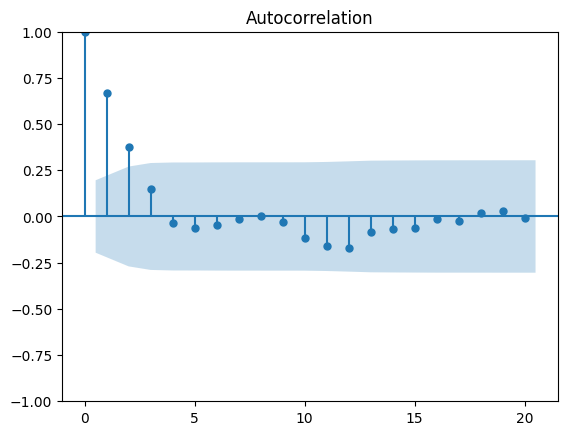

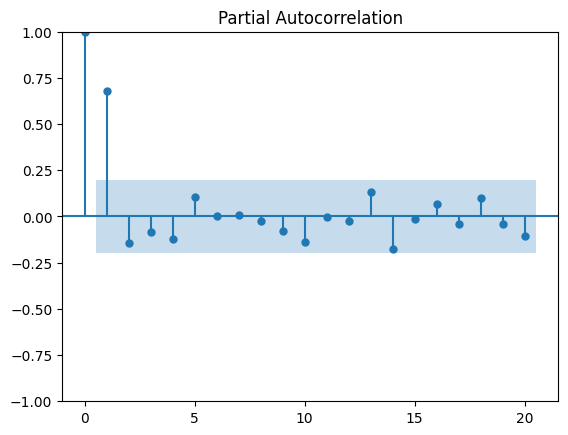

In [2]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
plot_acf(my_simulation)  # ACF
plot_pacf(my_simulation) # PACF

In [3]:
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

mod = sm.tsa.arima.ARIMA(my_simulation, order=(2, 0, 0))
mod_fit = mod.fit()
print(mod_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -149.612
Date:                Mon, 24 Apr 2023   AIC                            307.223
Time:                        02:15:44   BIC                            317.644
Sample:                             0   HQIC                           311.441
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0644      0.302     -0.213      0.831      -0.657       0.528
ar.L1          0.7931      0.107      7.412      0.000       0.583       1.003
ar.L2         -0.1667      0.106     -1.570      0.1

There are 7811 observations in the training data
There are 0 observations in the test data


<Axes: xlabel='Date'>

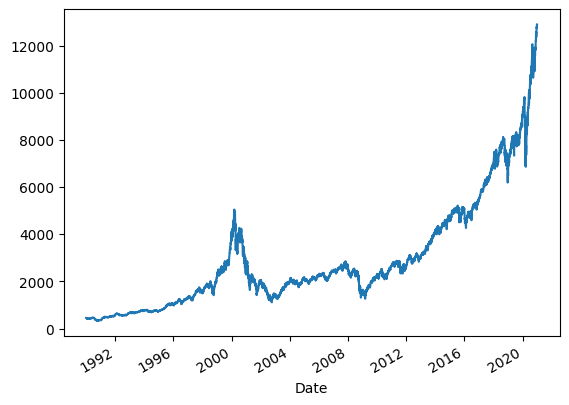

In [4]:
import pandas as pd
import yfinance as yf

AMZN = yf.download('^IXIC', 
                      start='1990-01-01', 
                      end='2020-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2021'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2022':].shape[0]) + " observations in the test data")
all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

In [5]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

def actual_pred_plot(preds):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2022':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)  

NameError: ignored

8/8 [==============================] - 0s 2ms/step


(7500481.5, <Axes: xlabel='Date'>)

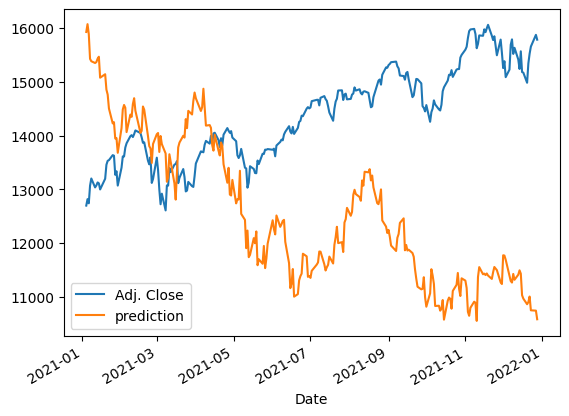

In [ ]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2021'].iloc[:,0:1].values
    ts_test  = all_data['2022':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2021'], all_data["Adj Close"]['2022':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)   

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 3ms/step


(8124490.5, <Axes: xlabel='Date'>)

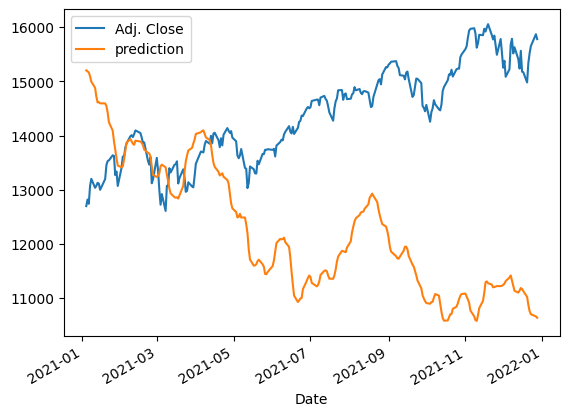

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  